# Maximum likelihood methods in Phylogenetics

These notes will describe models in phylogenetics and maximum likelihood parameter estimation from first principles in Python. On the models side, first principles will mean all the way to a mathematical derivation of the generative model for phylogenetic data and how the likelihood results from this. On the coding side, we'll be using several "mid" level packages, such as numpy, scipy, and so on. Hence we will not concern ourselves much with memory allocation or manipulating array data, but we will implement algorithms from scratch instead of relying on an existing package. First, the standard imports...

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from random import seed
from numpy.matlib import repmat
from scipy.linalg import expm
from ete3 import PhyloTree
from scipy.optimize import minimize
from multiprocessing import Pool
%matplotlib inline

And some preliminaries...

In [2]:
# Two sources of random number generation
random_seed = 1
np.random.seed(random_seed)
seed(random_seed)
NUMBER_OF_PROCESSORS = 10

## Markov chain substitution models

As is commonly done, we assume sequences evolve according to continuous time Markov chain models. Mathematically speaking, these are stochastic processes $N_t$ that satisfy
$$ P(N_{t+\Delta t} = j | N_t = i) = \delta_{ij} + \Delta t q_{ij} + o (\Delta t). $$

For simplicity we'll consider nucleotide models. We'll use F81 model with rate matrix
$$ Q = 
\begin{bmatrix}
\cdot & \pi_G & \pi_C & \pi_T \\
\pi_A & \cdot & \pi_C & \pi_T \\
\pi_A & \pi_G & \cdot & \pi_T \\
\pi_A & \pi_G & \pi_C & \cdot
\end{bmatrix}.
$$
As usual, the diagonals are omitted and replaced with dots, since they must satisfy $ q_{ii} = -\sum_{j=1}^n q_{ij} $, which ensures that rows sum to zero. Also, the rate matrix is divided by the overall substitution rate $ \mu = \sum_{i=1}^n \pi_i q_{ii} $, so that branch lengths are measured in expected numbers of substitutions per site (i.e., for the scaled rate matrix, this quantity should be 1).

The following code builds this matrix and checks that the above two properties are satisfied.

In [3]:
def f81(pi):
    piA = pi[0]
    piG = pi[1]
    piC = pi[2]
    piT = pi[3]
    beta = 1-np.sum(pi**2)
    Q = np.array([[0,   piG, piC, piT],
                  [piA, 0,   piC, piT],
                  [piA, piG, 0,   piT],
                  [piA, piG, piC, 0  ]])
    np.fill_diagonal(Q, -np.sum(Q, 1))
    Q /= beta
    return Q

pi = np.array([.1, .2, .3, .4])
Q = f81(pi)
print('These should all be near zero: {0}'.format(np.sum(Q, 1)))
print('This should be near one: {0}'.format(np.dot(-np.diag(Q), pi)))

These should all be near zero: [  1.11022302e-16  -1.11022302e-16  -1.11022302e-16  -1.11022302e-16]
This should be near one: 1.0000000000000002


Intuitively, the above definition states that nucletodies are changing (on average) from state $i$ to state $j$ at a rate of $q_{ij}$. This can be showing to imply that
$$ p_{ij}(t) := P(X_t = j | X_0 = i) = [e^{tQ}]_{ij} .$$
One often makes the (quite dubious) assumption that sites evolve independently. 

In [4]:
nucleotides = np.array(list('AGCT'), dtype='<U1')
to_str = lambda x: ''.join(nucleotides[x])

def mutate_sequence(sequence, Q, l):
    u = Q.shape[0]
    P = expm(l*Q)
    new_sequence = np.empty(sequence_length, dtype=np.int)
    all_indices = np.arange(sequence_length)
    for i in range(u):
        indices = all_indices[sequence==i]
        count = len(indices)
        transition_probabilities = P[i, :]
        new_nucleotides = np.random.choice(u, count, p=transition_probabilities)
        new_sequence[indices] = new_nucleotides
    return new_sequence

sequence_length = 50
l = .05
initial_sequence = np.random.choice(4, size=sequence_length, p=pi)
print('Initial sequence: %s' % to_str(initial_sequence))
mutated_sequence = mutate_sequence(initial_sequence, Q, l)
print('Mutated sequence: %s' % to_str(mutated_sequence))
percent_change = np.sum(initial_sequence != mutated_sequence) / sequence_length
print('Percent change: %.2f versus branch length: %.2f' % (percent_change, l))

Initial sequence: CTACGAGCCCCTGTATCCGGTTCTTTAAGTACTCTCTTATTTGTGCTGGG
Mutated sequence: CTACGAGCCCCTGTATCCGGTTCTTTAAGTACTCTCTTATTTGAGCTGGG
Percent change: 0.02 versus branch length: 0.05


Exposition will continue here... <img src="images/simple_tree.svg" style="float:right;"/>

In [5]:
extant_taxa = 20
shortest_branch_length = .01
longest_branch_length = .5
branch_range = (shortest_branch_length, longest_branch_length)

# This is done to be compatible with ete3's link_to_alignment below
names_as_strings = [str(i) for i in range(extant_taxa)]
tree = PhyloTree(format=1)
tree.populate(extant_taxa, random_branches=True, branch_range=branch_range, names_library=names_as_strings)
current_name = 2*extant_taxa-2
for node in tree.traverse('preorder'):
    if not node.is_leaf():
        node.name = str(current_name)
        current_name -= 1

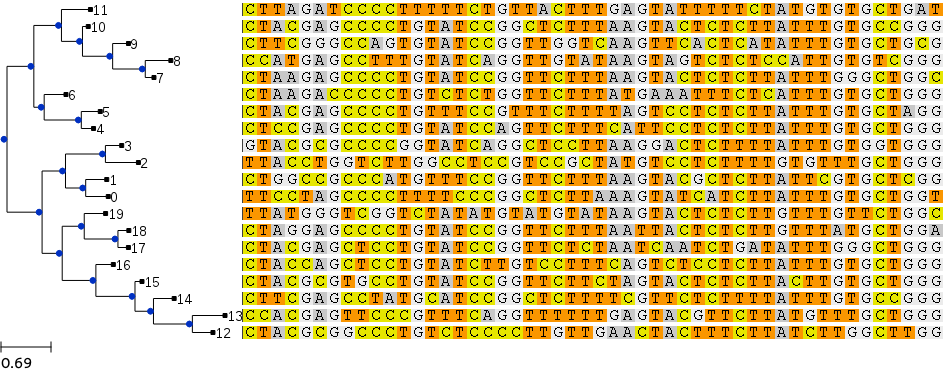

In [6]:
data = np.empty((2*extant_taxa-1, sequence_length), dtype=np.int)
for node in tree.traverse('preorder'):
    index = int(node.name)
    if node.is_root():
        data[index, :] = initial_sequence
        node.dist = 0
    else:
        parent_index = int(node.up.name)
        parent_sequence = data[parent_index, :]
        l = node.dist
        new_sequence = mutate_sequence(initial_sequence, Q, l)
        data[index, :] = new_sequence

fasta = '\n'.join(['>%d\n%s' % (i, ''.join(nucleotides[data[i, :]])) for i in range(extant_taxa)])
tree.link_to_alignment(fasta)
tree.render('%%inline')

In [7]:
def prune(data, tree, Q, pi):
    taxa = data.shape[0]
    sequence_length = data.shape[1]
    L = np.zeros((4, sequence_length, 2*taxa-1))
    all_sequence_indices = np.arange(sequence_length)
    for node in tree.traverse('postorder'):
        index = int(node.name)
        if node.is_leaf():
            sequence = data[index, :]
            L[sequence, all_sequence_indices, index] = 1
        else:
            left_child, right_child = node.children
            left_index = int(left_child.name)
            right_index = int(right_child.name)
            L_left = L[:, :, left_index]
            L_right = L[:, :, right_index]
            t_left = left_child.dist
            t_right = right_child.dist
            P_left = expm(t_left*Q)
            P_right = expm(t_right*Q)
            L[:, :, index] = np.dot(P_left, L_left) * np.dot(P_right, L_right)
        if node.is_root():
            l0 = np.dot(pi, L[:, :, index])
            return np.sum(np.log(l0))

pi0 = np.array([.25, .25, .25, .25])
sumtoone = lambda x: np.sum(x[-4:])-1
constraints = {'type':'eq', 'fun':sumtoone}
bounds = 4*((0,2),)

def negative_likelihood(pi, data):
    Q = f81(pi)
    return -prune(data, tree, Q, pi)

def optimization_result(pi0):
    objective = lambda pi: negative_likelihood(pi, data)
    result = minimize(objective, pi0, bounds=bounds, constraints=constraints)
    approx = result.x
    return approx
approx = optimization_result(pi0)
print(approx)

[ 0.13686532  0.20696289  0.28129022  0.37488157]


In [8]:
bootstrap_replicates = 10 * NUMBER_OF_PROCESSORS

def bootstrap_replicate(seed=None):
    if seed != None:
        np.random.seed(seed)
    inds = np.random.randint(sequence_length, size=sequence_length)
    objective = lambda x: negative_likelihood(x, data[:, inds])
    result = minimize(objective, pi0, bounds=bounds, constraints=constraints)
    approx = result.x
    return approx

p = Pool(12)
all_replicates = p.map(bootstrap_replicate, range(bootstrap_replicates))
p.close()

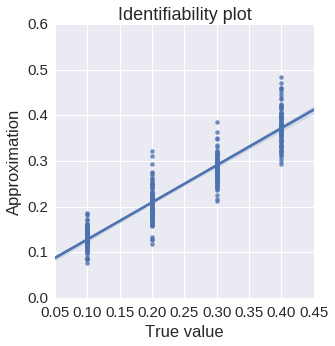

In [9]:
true_values = repmat(pi, bootstrap_replicates, 1).flatten()
all_replicates = np.array(all_replicates).flatten()
df = pd.DataFrame(
    {'True value': true_values, 'Approximation': all_replicates}
)

sns.set(font_scale=1.5)
sns.lmplot(x='True value', y='Approximation', data=df)
sns.plt.title('Identifiability plot')
plt.show()